C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_14008\2357901856.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  opponent_info = games_info.groupby('game_id').apply(get_opponent).reset_index(name='Opponent')


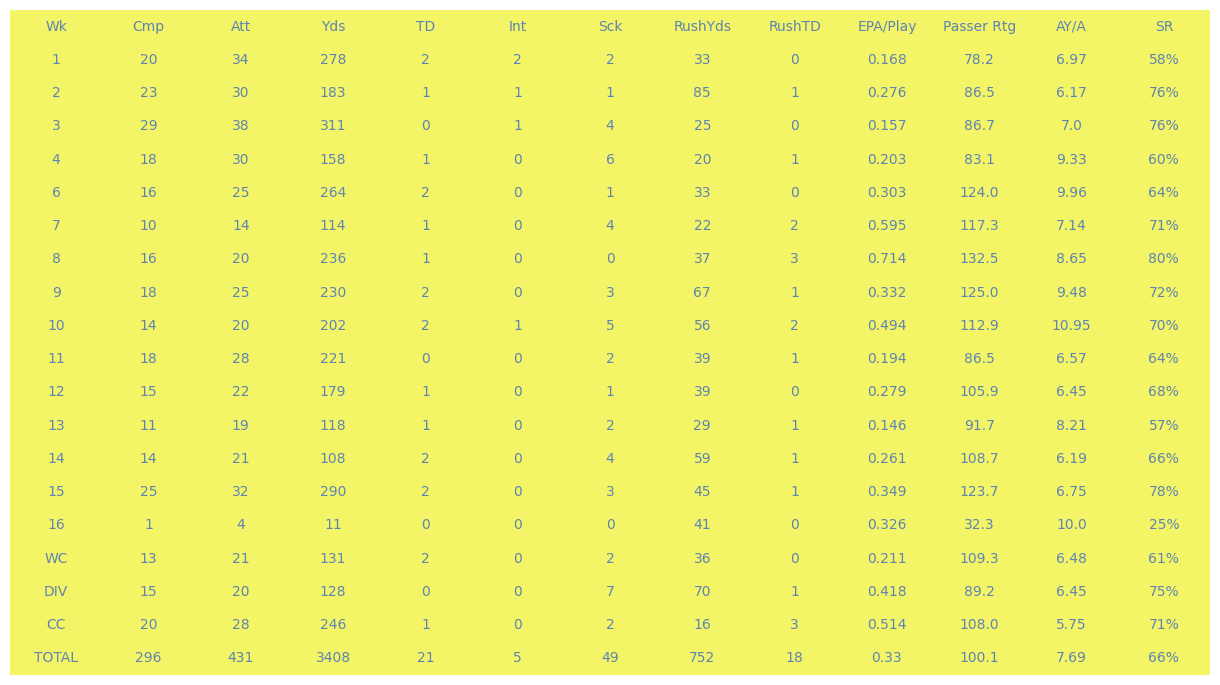

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

YEAR = 2024
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

df_pass = data[(data['passer_player_name'] == 'J.Hurts') & (data['pass_attempt'] == 1)].copy()
df_pass['is_sack'] = df_pass['sack'] == 1.0
df_pass_nosack = df_pass[~df_pass['is_sack']]

passing_stats = df_pass_nosack.groupby(['game_id', 'week']).agg(
    Cmp=('complete_pass', 'sum'),
    Yds=('passing_yards', 'sum'),
    TD=('pass_touchdown', 'sum'),
    Int=('interception', 'sum'),
    Att=('pass_attempt', 'count'), 
    AirYds=('air_yards', 'sum'),
    PassEPA=('epa', 'sum')
).reset_index()

sack_stats = df_pass[df_pass['is_sack']].groupby(['game_id', 'week']).size().reset_index(name='Sck')
passing_stats = passing_stats.merge(sack_stats, on=['game_id', 'week'], how='left')
passing_stats['Sck'] = passing_stats['Sck'].fillna(0).astype(int)

df_rush = data[data['rusher_player_name'] == 'J.Hurts']
rushing_stats = df_rush.groupby(['game_id', 'week']).agg(
    RushAtt=('rush_attempt', 'sum'),
    RushYds=('rushing_yards', 'sum'),
    RushTD=('rush_touchdown', 'sum'),
    RushEPA=('epa', 'sum')
).reset_index()

game_stats = pd.merge(passing_stats, rushing_stats, on=['game_id', 'week'], how='outer')

stat_cols = ['Cmp', 'Yds', 'TD', 'Int', 'Att', 'AirYds', 'PassEPA', 
             'Sck', 'RushAtt', 'RushYds', 'RushTD', 'RushEPA']
for col in stat_cols:
    if col in game_stats.columns:
        game_stats[col] = game_stats[col].fillna(0)

game_stats['TotalEPA'] = game_stats['PassEPA'] + game_stats['RushEPA']
game_stats['TotalPlays'] = game_stats['Att'] + game_stats['RushAtt']
game_stats['EPA/Play'] = game_stats.apply(
    lambda row: round(row['TotalEPA'] / row['TotalPlays'], 3) if row['TotalPlays'] > 0 else 0, axis=1)
game_stats['AY/A'] = game_stats.apply(
    lambda row: round(row['AirYds'] / row['Att'], 2) if row['Att'] > 0 else 0, axis=1)
game_stats['Success Rate'] = game_stats.apply(
    lambda row: round((row['Cmp'] / row['Att']) * 100, 1) if row['Att'] > 0 else 0, axis=1)

def calculate_passer_rating(row):
    if row['Att'] > 0:
        comp_pct = row['Cmp'] / row['Att']
        avg_yards = row['Yds'] / row['Att']
        td_pct = row['TD'] / row['Att']
        int_pct = row['Int'] / row['Att']
        rating = (comp_pct * 5 + avg_yards * 0.25 + td_pct * 20 - int_pct * 25) / 6 * 100
        return round(rating, 1)
    else:
        return 0

game_stats['Passer Rtg'] = game_stats.apply(calculate_passer_rating, axis=1)

def get_opponent(group):
    row = group.iloc[0]
    if row['home_team'] == 'PHI':
        return f"vs. {row['away_team']}"
    else:
        return f"@ {row['home_team']}"

games_info = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]
opponent_info = games_info.groupby('game_id').apply(get_opponent).reset_index(name='Opponent')
week_info = games_info.groupby('game_id')['week'].first().reset_index()
opponent_info = opponent_info.merge(week_info, on='game_id', how='left')
game_stats = game_stats.merge(opponent_info, on=['game_id', 'week'], how='left')

final_columns = ['week', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Sck', 
                 'RushYds', 'RushTD', 'EPA/Play', 'Passer Rtg', 'AY/A', 'Success Rate']
final_stats = game_stats[final_columns].copy()
final_stats = final_stats.sort_values('week')

final_stats['week'] = final_stats['week'].replace({19: 'WC', 20: 'DIV', 21: 'CC'})

final_stats = final_stats.rename(columns={
    'week': 'Wk',
    'Cmp': 'Cmp',
    'Att': 'Att',
    'Yds': 'Yds',
    'TD': 'TD',
    'Int': 'Int',
    'Sck': 'Sck',
    'RushYds': 'RushYds',
    'RushTD': 'RushTD',
    'EPA/Play': 'EPA/Play',
    'Passer Rtg': 'Passer Rtg',
    'AY/A': 'AY/A',
    'Success Rate': 'SR'
})

cols_to_format = ['Cmp', 'Yds', 'TD', 'Int', 'RushYds', 'RushTD']
for col in cols_to_format:
    final_stats[col] = final_stats[col].astype(int)

final_stats['SR'] = final_stats['SR'].apply(lambda x: f"{int(x)}%")

totals = {
    'Wk': 'TOTAL',
    'Cmp': final_stats['Cmp'].sum(),
    'Att': final_stats['Att'].sum(),
    'Yds': final_stats['Yds'].sum(),
    'TD': final_stats['TD'].sum(),
    'Int': final_stats['Int'].sum(),
    'Sck': final_stats['Sck'].sum(),
    'RushYds': final_stats['RushYds'].sum(),
    'RushTD': final_stats['RushTD'].sum(),
    'EPA/Play': round(final_stats['EPA/Play'].mean(), 3),
    'Passer Rtg': round(final_stats['Passer Rtg'].mean(), 1),
    'AY/A': round(final_stats['AY/A'].mean(), 2),
    'SR': f"{int(final_stats['SR'].str.rstrip('%').astype(int).mean())}%"
}

final_stats = pd.concat([final_stats, pd.DataFrame([totals])], ignore_index=True)

fig_height = 0.35 * len(final_stats)
fig, ax = plt.subplots(figsize=(12, fig_height))
ax.axis('off')
fig.patch.set_alpha(0)

the_table = ax.table(cellText=final_stats.values,
                     colLabels=final_stats.columns,
                     cellLoc='center',
                     loc='center')

the_table.scale(1, 0.6)

for (i, j), cell in the_table.get_celld().items():
    cell.set_linewidth(0)
    cell.set_facecolor("#f3f566")
    cell.set_height(0.05)
    cell.get_text().set_color("#5f84b1")
    cell.get_text().set_fontsize(18)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save the figure
plt.savefig('hurts_stats_yellow.png', format='png', transparent=True, bbox_inches='tight', pad_inches=0)

plt.show()
